<a href="https://colab.research.google.com/github/StellarApp/dl-image-recognition/blob/master/Inpainting_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

#reference 
https://github.com/ayulockin/deepimageinpainting


In [1]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 48kB/s 
     |████████████████████████████████| 450kB 42.4MB/s 
     |████████████████████████████████| 3.8MB 48.9MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=9dff05db4ee974f2c6ad1bb6f0d35dab19231fbdf49ee65df906454a0b7a14a9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing insta

In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.0.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [4]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

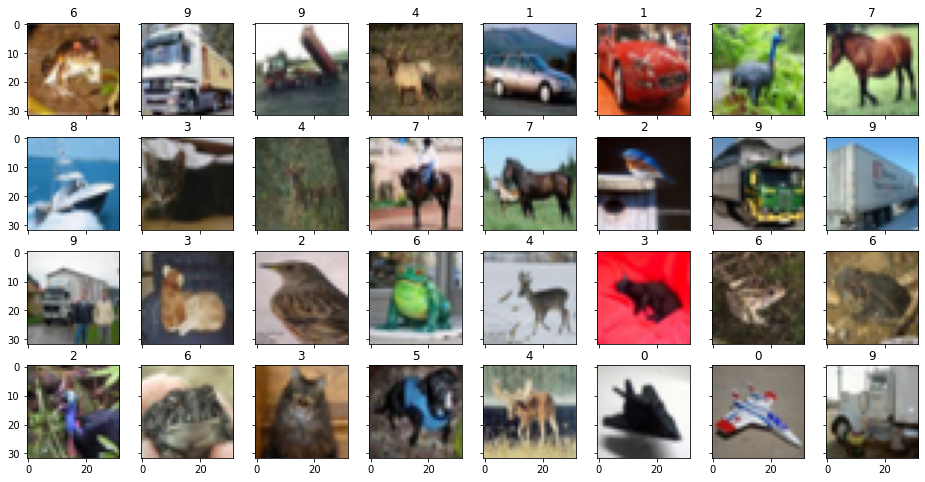

In [5]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [6]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

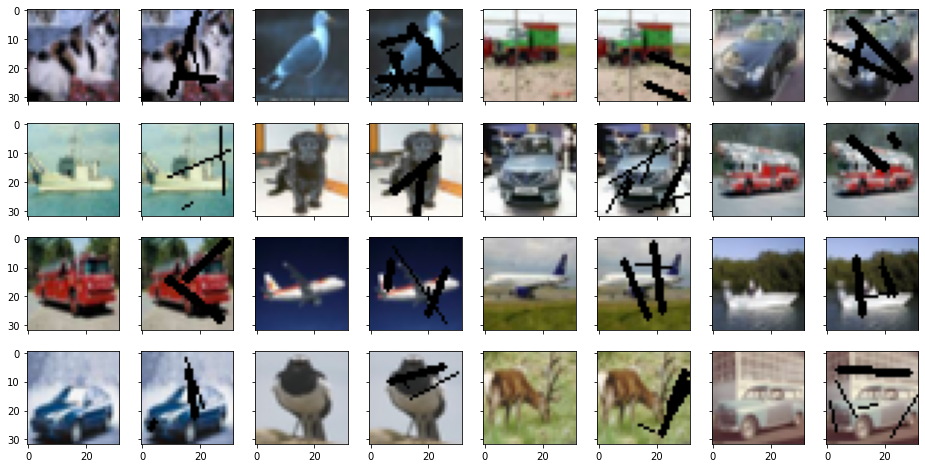

In [8]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [9]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [10]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

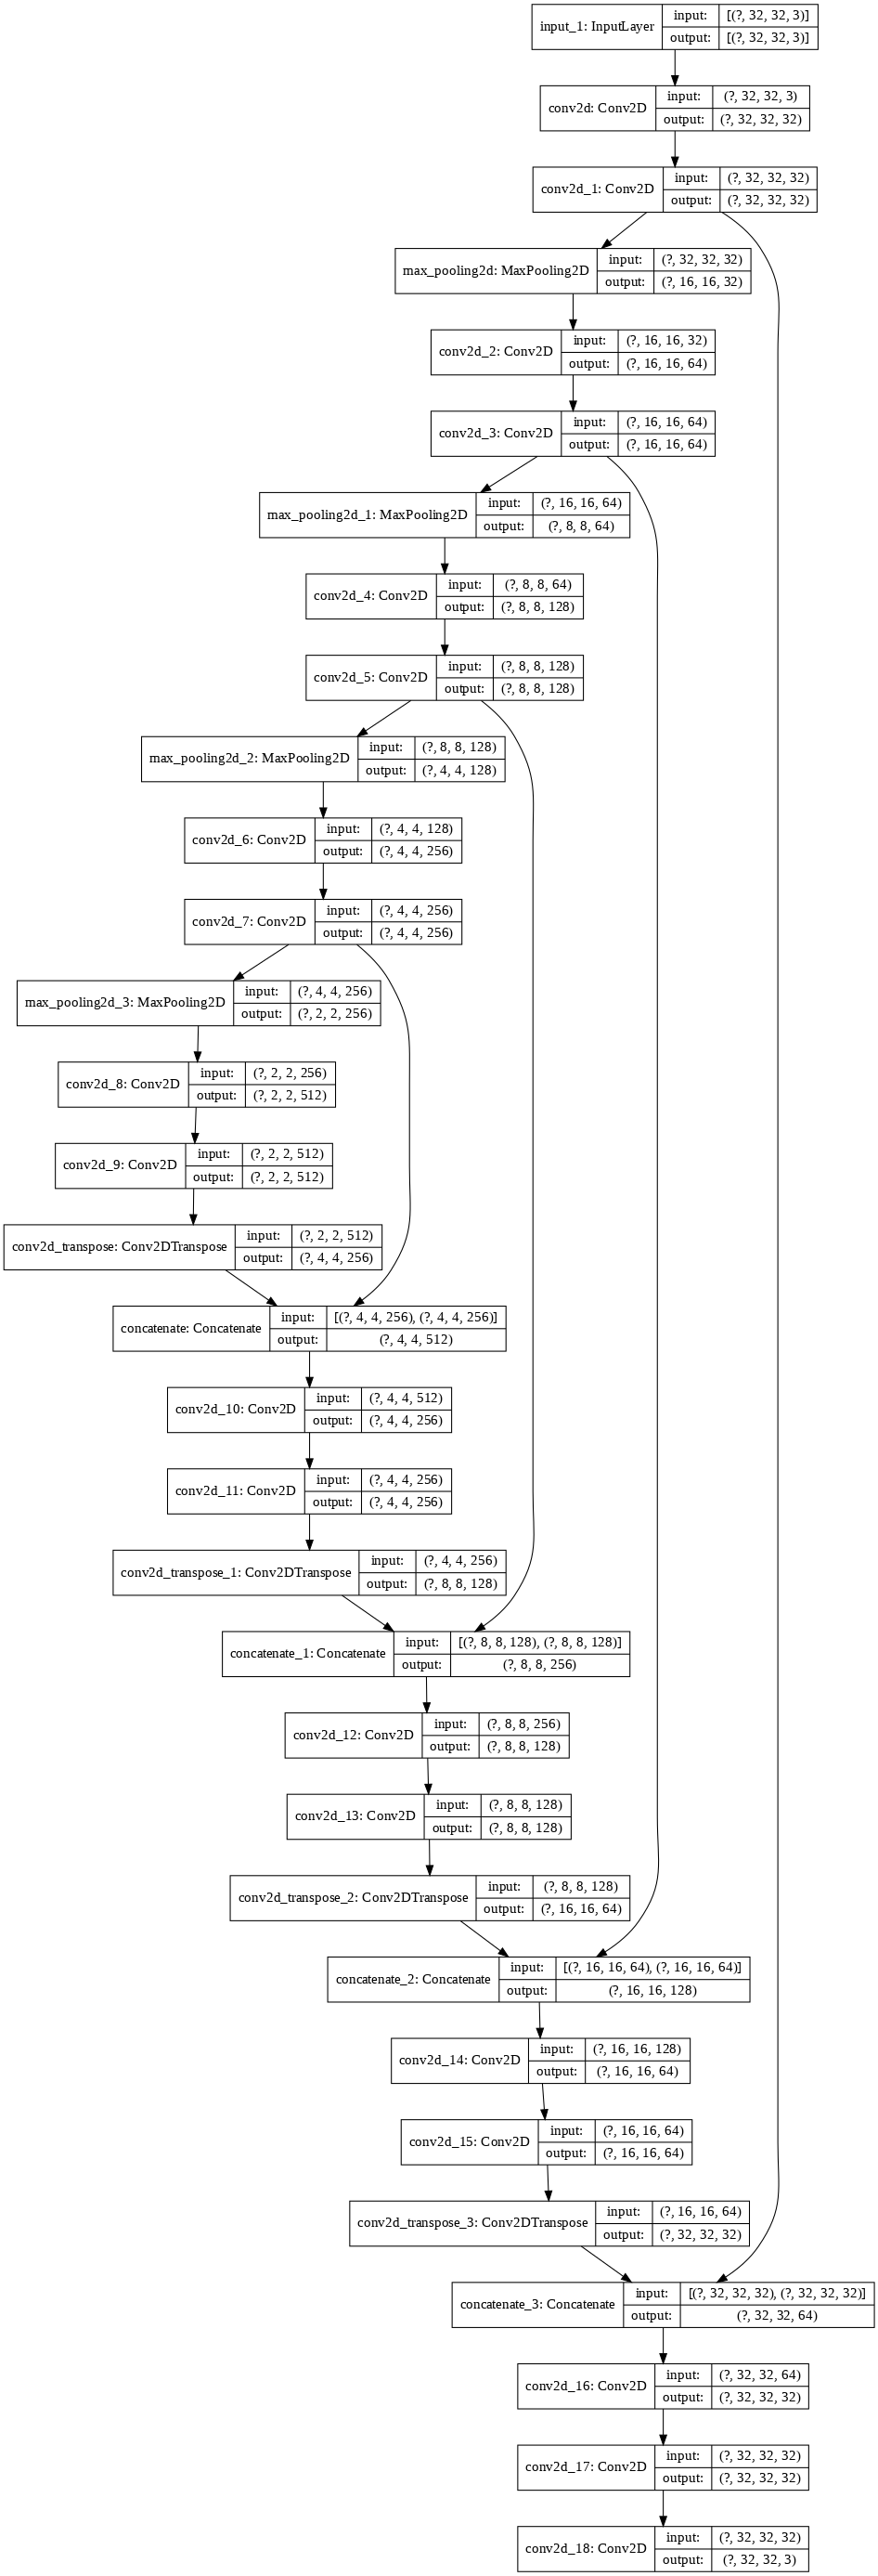

In [11]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

# Train

In [12]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        sample_images, sample_labels = testgen[sample_idx]  
        
        images = []
        labels = []
        predictions = []
        
        for i in range(32):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

In [135]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[
                     PredictionLogger()])

Train for 1562 steps, validate for 312 steps
Epoch 1/20
1562/1562 [==============================] - 44s 28ms/step - loss: 0.0224 - dice_coef: 0.6023 - val_loss: 0.0207 - val_dice_coef: 0.6007
Epoch 2/20
1562/1562 [==============================] - 43s 28ms/step - loss: 0.0199 - dice_coef: 0.6029 - val_loss: 0.0203 - val_dice_coef: 0.6098
Epoch 3/20
1562/1562 [==============================] - 43s 28ms/step - loss: 0.0186 - dice_coef: 0.6032 - val_loss: 0.0154 - val_dice_coef: 0.6055
Epoch 4/20
1562/1562 [==============================] - 44s 28ms/step - loss: 0.0174 - dice_coef: 0.6033 - val_loss: 0.0187 - val_dice_coef: 0.6088
Epoch 5/20
1562/1562 [==============================] - 44s 28ms/step - loss: 0.0167 - dice_coef: 0.6035 - val_loss: 0.0167 - val_dice_coef: 0.6049
Epoch 6/20
1562/1562 [==============================] - 43s 28ms/step - loss: 0.0164 - dice_coef: 0.6035 - val_loss: 0.0143 - val_dice_coef: 0.6058
Epoch 7/20
1562/1562 [==============================] - 44s 28ms/st

In [136]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [137]:
rows = 32
sample_idx = 54
sample_images, sample_labels = traingen[sample_idx]
print(sample_images[1].reshape((1,)+sample_images[1].shape).shape)


(1, 32, 32, 3)


In [138]:
model.predict(sample_images[1].reshape((1,)+sample_images[1].shape))

array([[[[0.71872056, 0.827709  , 0.8989212 ],
         [0.71683407, 0.82256234, 0.90058976],
         [0.71826214, 0.82390124, 0.8938237 ],
         ...,
         [0.5930122 , 0.7327807 , 0.8676505 ],
         [0.5877559 , 0.7208772 , 0.8643383 ],
         [0.60952353, 0.7299243 , 0.8680459 ]],

        [[0.707245  , 0.8199192 , 0.8999338 ],
         [0.7012335 , 0.8082863 , 0.87794924],
         [0.70309585, 0.80728674, 0.87489754],
         ...,
         [0.5687729 , 0.7005534 , 0.84464127],
         [0.56309634, 0.69692034, 0.8423327 ],
         [0.56883913, 0.7091093 , 0.85967445]],

        [[0.7036417 , 0.81110984, 0.8855194 ],
         [0.6924497 , 0.7958431 , 0.86214817],
         [0.694334  , 0.79855764, 0.8646178 ],
         ...,
         [0.5464974 , 0.682174  , 0.82849026],
         [0.5406932 , 0.68306816, 0.8354537 ],
         [0.5439107 , 0.692647  , 0.8525592 ]],

        ...,

        [[0.32466334, 0.3707795 , 0.3413111 ],
         [0.32954285, 0.37070972, 0.34584546]

# Load Model


In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/gdrive/MyDrive/Colab Notebooks/Inpainting/model_ia.h5")

# model.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Inpainting/model_weights_ia.h5")

ValueError: ignored

# Testing on images

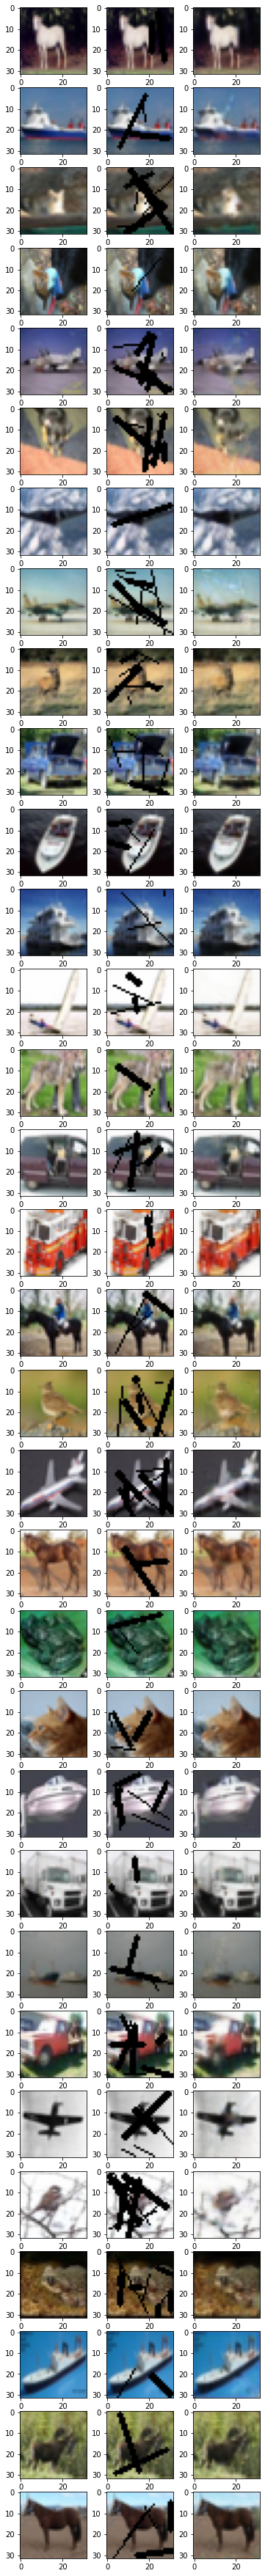

In [ ]:
## Examples
rows = 32
sample_idx = 54
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

In [29]:
sample_images[1].dtype

dtype('float64')

In [141]:
model.save('model_ia.h5')
model.save_weights('weights_ia.h5')

In [189]:
# upload external file before import
from google.colab import files

files.download("model_ia.h5")
files.download('weights_ia.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
# uploading images to google drive
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


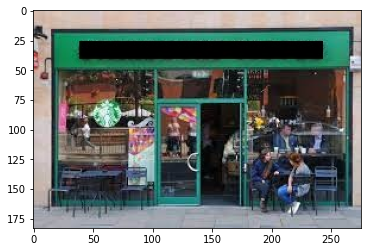

(183, 276, 3)

In [143]:
from tensorflow.keras.preprocessing import image
import cv2
img = cv2.imread('/content/Masked_Starbucks_01.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

img.shape

In [144]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/Starbucks_01.jpg', target_size=(32, 32, 3))
print(type(img))
print(img.mode)

img = np.asarray(img)
print(img.dtype)

img = img.astype('float64')
img = img / 255
print(img.shape)

print("converted data type", img.dtype)
img.shape

<class 'PIL.Image.Image'>
RGB
uint8
(32, 32, 3)
converted data type float64


(32, 32, 3)

In [ ]:
#!pip install --upgrade keras numpy pandas sklearn pillow

In [145]:
masked_img = image.load_img('/content/Masked_Starbucks_01.jpg', target_size=(32, 32, 3))
print(type(masked_img))
print(masked_img.mode)

masked_img = np.asarray(masked_img)
print(masked_img.dtype)

masked_img = masked_img.astype('float64')
masked_img = masked_img / 255
print(masked_img.shape)

print("converted data type", masked_img.dtype)
masked_img

<class 'PIL.Image.Image'>
RGB
uint8
(32, 32, 3)
converted data type float64


array([[[0.83137255, 0.7372549 , 0.69019608],
        [0.85098039, 0.76470588, 0.72156863],
        [0.8745098 , 0.78823529, 0.7372549 ],
        ...,
        [0.84313725, 0.76862745, 0.71372549],
        [0.85882353, 0.78431373, 0.75686275],
        [0.83921569, 0.76862745, 0.72156863]],

       [[0.80392157, 0.70980392, 0.6627451 ],
        [0.85490196, 0.73333333, 0.6627451 ],
        [0.82745098, 0.74117647, 0.68627451],
        ...,
        [0.86666667, 0.75294118, 0.69803922],
        [0.8627451 , 0.79215686, 0.75294118],
        [0.84313725, 0.77254902, 0.69411765]],

       [[0.08235294, 0.05098039, 0.04313725],
        [0.81176471, 0.7254902 , 0.68235294],
        [0.79607843, 0.72156863, 0.66666667],
        ...,
        [0.35294118, 0.35294118, 0.4       ],
        [0.28235294, 0.27058824, 0.31372549],
        [0.78823529, 0.75686275, 0.74509804]],

       ...,

       [[0.61176471, 0.62745098, 0.67058824],
        [0.41176471, 0.42745098, 0.47058824],
        [0.52156863, 0

In [146]:
inpainted_img = model.predict(masked_img.reshape((1,)+masked_img.shape))

In [156]:
import os
print( os.getcwd() )
print( os.listdir('drive') )

/content
['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0']


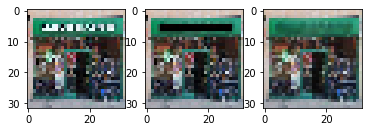

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))


axs[0].imshow(img)
axs[1].imshow(masked_img)
axs[2].imshow(inpainted_img.reshape(inpainted_img.shape[1:]))

plt.show()

In [162]:
inpainted_img.save('Inpaint_Starbucks_01.jpg')

AttributeError: ignored

In [176]:
from PIL import Image as im

inpainted_img.reshape(inpainted_img.shape[1:]).shape
new_img = inpainted_img.reshape(inpainted_img.shape[1:])
new_img.shape

(32, 32, 3)

In [187]:
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img

save_img('Inpainting_Starbucks_01.jpg', new_img)
Inpainting_Starbucks_01 = load_img('Inpainting_Starbucks_01.jpg')


In [188]:
Inpainting_Starbucks_01.show()